In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 53kB/s 


coup_predictor.py

In [ ]:
import numpy as np

from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import statistics

class CoupPredictorModel:
    def __init__(self):
        self.model1 = KNeighborsClassifier(5)
        self.model2 = LogisticRegression()
        self.model3 = CatBoostClassifier(max_depth=5, iterations=30000, early_stopping_rounds=10, auto_class_weights='Balanced')
        self.fitted = False

    def fit(self, _X_train, _y_train):
        self.model1.fit(_X_train, _y_train)
        self.model2.fit(_X_train, _y_train)
        self.model3.fit(_X_train, _y_train)

    def predict_proba(self, _X_test):
        predicted_1 = self.model1.predict_proba(_X_test)[:, 1]
        predicted_2 = self.model3.predict_proba(_X_test)[:, 1]
        predicted_3 = self.model3.predict_proba(_X_test)[:, 1]
        final_predicted = np.zeros(len(predicted_1))
        for i in range(len(predicted_1)):
            print([ predicted_1[i], predicted_2[i], predicted_3[i] ])
            final_predicted[i] = statistics.median([ predicted_1[i], predicted_2[i], predicted_3[i] ])
        return final_predicted

    def predict(self, _X_test):
        predicted_1 = self.model1.predict_proba(_X_test)[:, 1]
        predicted_2 = self.model3.predict_proba(_X_test)[:, 1]
        predicted_3 = self.model3.predict_proba(_X_test)[:, 1]
        final_predicted = np.zeros(len(predicted_1))
        for i in range(len(predicted_1)):
            print([ predicted_1[i], predicted_2[i], predicted_3[i] ])
            final_predicted[i] = int(statistics.median([ predicted_1[i], predicted_2[i], predicted_3[i] ]) > 0.8)
        return final_predicted   

data_preporation.py

In [ ]:
import pandas as pd

class DatasetMaker:
    def __init__(self, _first_year=1965, _last_year = 2019, _coupDeTat = pd.DataFrame(), _reign = pd.DataFrame(), _country_list = []):
        self.first_year = _first_year
        self.last_year = _last_year
        self.year_range_ = range(self.first_year, self.last_year)
        self.coupDeTat = _coupDeTat
        self.reign = _reign

        if _country_list == []:
            self.country_list = pd.unique(self.coupDeTat['country']).tolist()
        else:
            self.country_list = _country_list

        if self.coupDeTat.empty:
            self.time_to_series_full_year_range = pd.DataFrame()
        else:
            self.time_to_series_full_year_range = self.transform_to_fullRange_time_series()

    def sample(self, n):
        print("CoupDeTat")
        if not self.coupDeTat.empty:
            print(self.coupDeTat.sample(n))
        else:
            print(self.coupDeTat)
        print("=========================================\nReign")
        if not self.reign.empty:
            print(self.reign.sample(n))
        else:
            print(self.reign)

    def set_country_list(self, country_list):
        self.country_list = country_list

    def set_data(self, _coupDeTat = None, _reign = None):
        self.coupDeTat = _coupDeTat
        self.reign = _reign

    def transform_to_fullRange_time_series(self):
        df_country_year = self.coupDeTat[['country', 'year']]
        time_series_full_year_range = pd.DataFrame([['North African Respublic'] + [0 for i in self.year_range_]],
                                                   columns=['country'] + [str(i) for i in self.year_range_])
        for country_iter in self.country_list:
            if (not df_country_year[df_country_year['country'] == country_iter].empty):
                row = [country_iter] + \
                      [int(df_country_year[df_country_year['country'] == country_iter].isin([year]).sum().sum()) for
                       year in
                       self.year_range_]
            else:
                row = [country_iter] + [int(0) for year in self.year_range_]
            # print(row)
            time_series_full_year_range.loc[-1] = row
            time_series_full_year_range.index += 1
            time_series_full_year_range.sort_index()

        return time_series_full_year_range

    def transform_to_nYears_time_series(self, _last_n_years_number):
        self.time_series_last_nYears = pd.DataFrame(
            [['North African Respublic', 1950] + [0 for i in range(_last_n_years_number)] + [0]],
            columns=['country', 'target year', ] + ['coup in year - ' + str(i) for i in range(1, _last_n_years_number + 1)] + ['coup in target year']
        )
        target_year_range = range(self.first_year + _last_n_years_number, self.last_year)
        for country_iter in self.country_list:
            for target_year in target_year_range:
                row = [country_iter, target_year] + [
                    self.time_to_series_full_year_range[self.time_to_series_full_year_range['country'] == country_iter][str(target_year - i - 1)].sum() for i in
                    range(_last_n_years_number)] + [
                          (self.time_to_series_full_year_range[self.time_to_series_full_year_range['country'] == country_iter][str(target_year)].sum() != 0)]
                self.time_series_last_nYears.loc[-1] = row
                self.time_series_last_nYears.index += 1

        return self.time_series_last_nYears

main.py

In [ ]:
dm = DatasetMaker(1945, 2019, _coupDeTat=pd.read_csv('/content/drive/MyDrive/Предсказание гос переворотов/Colab Калиниченко М/final model/Coup_Data_v2.0.0_clean_with_un.csv'))
dm.sample(3)


CoupDeTat
     Unnamed: 0   country  year
997         997  Anguilla     0
203         203   Burundi  1996
820         820     Syria  1963
Reign
Empty DataFrame
Columns: []
Index: []


In [ ]:
dataset = dm.transform_to_nYears_time_series(_last_n_years_number=20)

In [ ]:
df_country = dataset.country
df_country_ohe = pd.get_dummies(df_country, columns=['country'], dummy_na=True)
y = dataset['coup in target year']
X = pd.concat([df_country_ohe, dataset.drop(['coup in target year', 'country'], 1)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2485)

model = CoupPredictorModel()
model.fit(X_train, y_train)


In [ ]:
predicted_prob = model.predict_proba(X_test)
predicted = [i > 0.5 for i in predicted_prob]

[0.0, 0.10436624048749817, 0.10436624048749817]
[0.0, 0.12348793472529175, 0.12348793472529175]
[0.0, 0.29728956269858947, 0.29728956269858947]
[0.0, 0.1507562935833999, 0.1507562935833999]
[0.0, 0.5917384158528883, 0.5917384158528883]
[0.2, 0.26166146097973575, 0.26166146097973575]
[0.0, 0.29641363252297387, 0.29641363252297387]
[0.2, 0.8562245312212504, 0.8562245312212504]
[0.0, 0.24198648769616818, 0.24198648769616818]
[0.0, 0.18368586840189724, 0.18368586840189724]
[0.0, 0.10478471616335219, 0.10478471616335219]
[0.0, 0.09856366148263031, 0.09856366148263031]
[0.0, 0.18988817273051062, 0.18988817273051062]
[0.0, 0.2841362504902405, 0.2841362504902405]
[0.0, 0.12297762397306972, 0.12297762397306972]
[0.0, 0.1049202561128465, 0.1049202561128465]
[0.0, 0.19922305186986702, 0.19922305186986702]
[0.0, 0.8918987299196395, 0.8918987299196395]
[0.0, 0.1926344239302288, 0.1926344239302288]
[0.0, 0.10495906848597454, 0.10495906848597454]
[0.2, 0.6253630530284043, 0.6253630530284043]
[0.0, 0.

In [ ]:
from matplotlib import pyplot as plt 


In [ ]:
y_test_with_answers = pd.DataFrame(y_test)
y_test_with_answers['probabilities'] = predicted_prob
y_test_with_answers['predicted'] = predicted

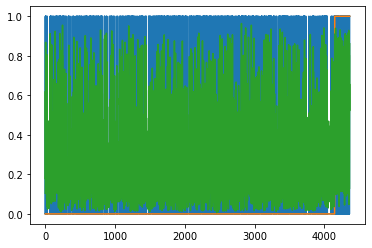

In [ ]:
plt.plot(y_test_with_answers.sort_values(['coup in target year'])['predicted'].to_list()[:])
plt.plot(y_test_with_answers.sort_values(['coup in target year'])['coup in target year'].to_list()[:])
plt.plot(y_test_with_answers.sort_values(['coup in target year'])['probabilities'].to_list()[:])
#

In [ ]:
roc_auc_score(y_test, predicted)

0.6718141719347119

In [ ]:
table = dm.time_series_last_nYears

In [ ]:
y_test.index

Int64Index([ 1957,  6177,  9569,  8094, 10458,  5660,  8793, 10821, 10160,
             9337,
            ...
             6814,  9974,  2078,  1685,  2252,  5647,  6348,  8550,  1678,
             5458],
           dtype='int64', length=4364)

In [ ]:
test_table = pd.DataFrame
for i in y_test.index.to_list():
  test_table[-1] = 